# Crab Age Prediction using Only data available from live crabs

### Group members: Andrea Galvan, Brandt Sandman, Nicholas Jurczyk

#### The data being used is downloaded from Kaggle.
##### https://www.kaggle.com/datasets/sidhus/crab-age-prediction/data

### Import Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set()

### Load and Inspect Data Set

In [6]:
# Fetch the file
original_data = pd.read_csv('CrabAgePrediction.csv') # Local, use full path if notebook and file in different folders! 

#Display What attributes we are working with in the Data
original_data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


## As we cannot measure the Viscera (organ) weight, shell weight, nor shucked weight without killing the crab, we will remove these from the dataset

In [8]:
original_data = original_data.drop(["Shucked Weight"], axis=1)
original_data = original_data.drop(["Viscera Weight"], axis=1)
original_data = original_data.drop(["Shell Weight"], axis=1)
original_data.head()

,Sex,Length,Diameter,Height,Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,9
1,M,0.8875,0.6500,0.2125,5.400580,6
2,I,1.0375,0.7750,0.2500,7.952035,6
3,F,1.1750,0.8875,0.2500,13.480187,10
4,I,0.8875,0.6625,0.2125,6.903103,6


In [165]:
original_data.describe(include='all') # descriptive statistics for all columns

,Sex,Length,Diameter,Height,Weight,Age
count,3893,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
unique,3,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN
freq,1435,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.311306,1.020893,0.349374,23.567275,9.954791
std,NaN,0.300431,0.248233,0.104976,13.891201,3.220967
min,NaN,0.187500,0.137500,0.000000,0.056699,1.000000
25%,NaN,1.125000,0.875000,0.287500,12.672227,8.000000
50%,NaN,1.362500,1.062500,0.362500,22.792998,10.000000
75%,NaN,1.537500,1.200000,0.412500,32.786197,11.000000


In [10]:
original_data.isnull().sum() # check for null values

Sex         0
Length      0
Diameter    0
Height      0
Weight      0
Age         0
dtype: int64

In [12]:
original_data[original_data.duplicated(keep=False)] # check for duplicate rows

,Sex,Length,Diameter,Height,Weight,Age


## Data Cleansing
#### Currently, the Sex of the crab is stored as a string (F/M/I for Male/Female/Indeterminate). We want to turn the string into a number. We will convert the string as follows:

##### F --> 0
##### M --> 1
##### I --> 2

In [14]:
#for the data, we need to turn the Label into a number so we can compare if we predicted the right thing.
# Step 1: Create a mapping dictionary
mapping = {
    'F': 0,
    'M': 1,
    'I': 2
}

# Step 2: Apply the mapping to the specific column
original_data['Sex'] = original_data['Sex'].map(mapping)

original_data.head()

,Sex,Length,Diameter,Height,Weight,Age
0,0,1.4375,1.1750,0.4125,24.635715,9
1,1,0.8875,0.6500,0.2125,5.400580,6
2,2,1.0375,0.7750,0.2500,7.952035,6
3,0,1.1750,0.8875,0.2500,13.480187,10
4,2,0.8875,0.6625,0.2125,6.903103,6


### We also only care about if a crab is edible or not. We don't care about how old the crab is in months. As such, we will re-classify the data so that we only look at if the crab is old enough to eat or not.

#### A crab is considered ready to eat starting at 12 months of age.

In [16]:
# Code source: ChatGPT
# Remap the 'age' column where age > 12 becomes 1 and age <= 12 becomes 0
original_data['Age'] = original_data['Age'].apply(lambda x: 1 if x > 11 else 0)

original_data.head()

,Sex,Length,Diameter,Height,Weight,Age
0,0,1.4375,1.1750,0.4125,24.635715,0
1,1,0.8875,0.6500,0.2125,5.400580,0
2,2,1.0375,0.7750,0.2500,7.952035,0
3,0,1.1750,0.8875,0.2500,13.480187,0
4,2,0.8875,0.6625,0.2125,6.903103,0


# Splitting the Data into Testing and Training Datasets

In [18]:
target = original_data["Age"]
predictors = original_data.drop(["Age"], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, test_size=0.2, random_state=42
)  # 80-20 split into training and test data

##### Check if the dataset is balanced.

In [22]:
# Check data balancing
y_train.value_counts()

# There is no severe skew in the class distribution. No resampling needed.
# If you want to learn more about resampling, also check https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

Age
0    2368
1     746
Name: count, dtype: int64

## Predictor Selection

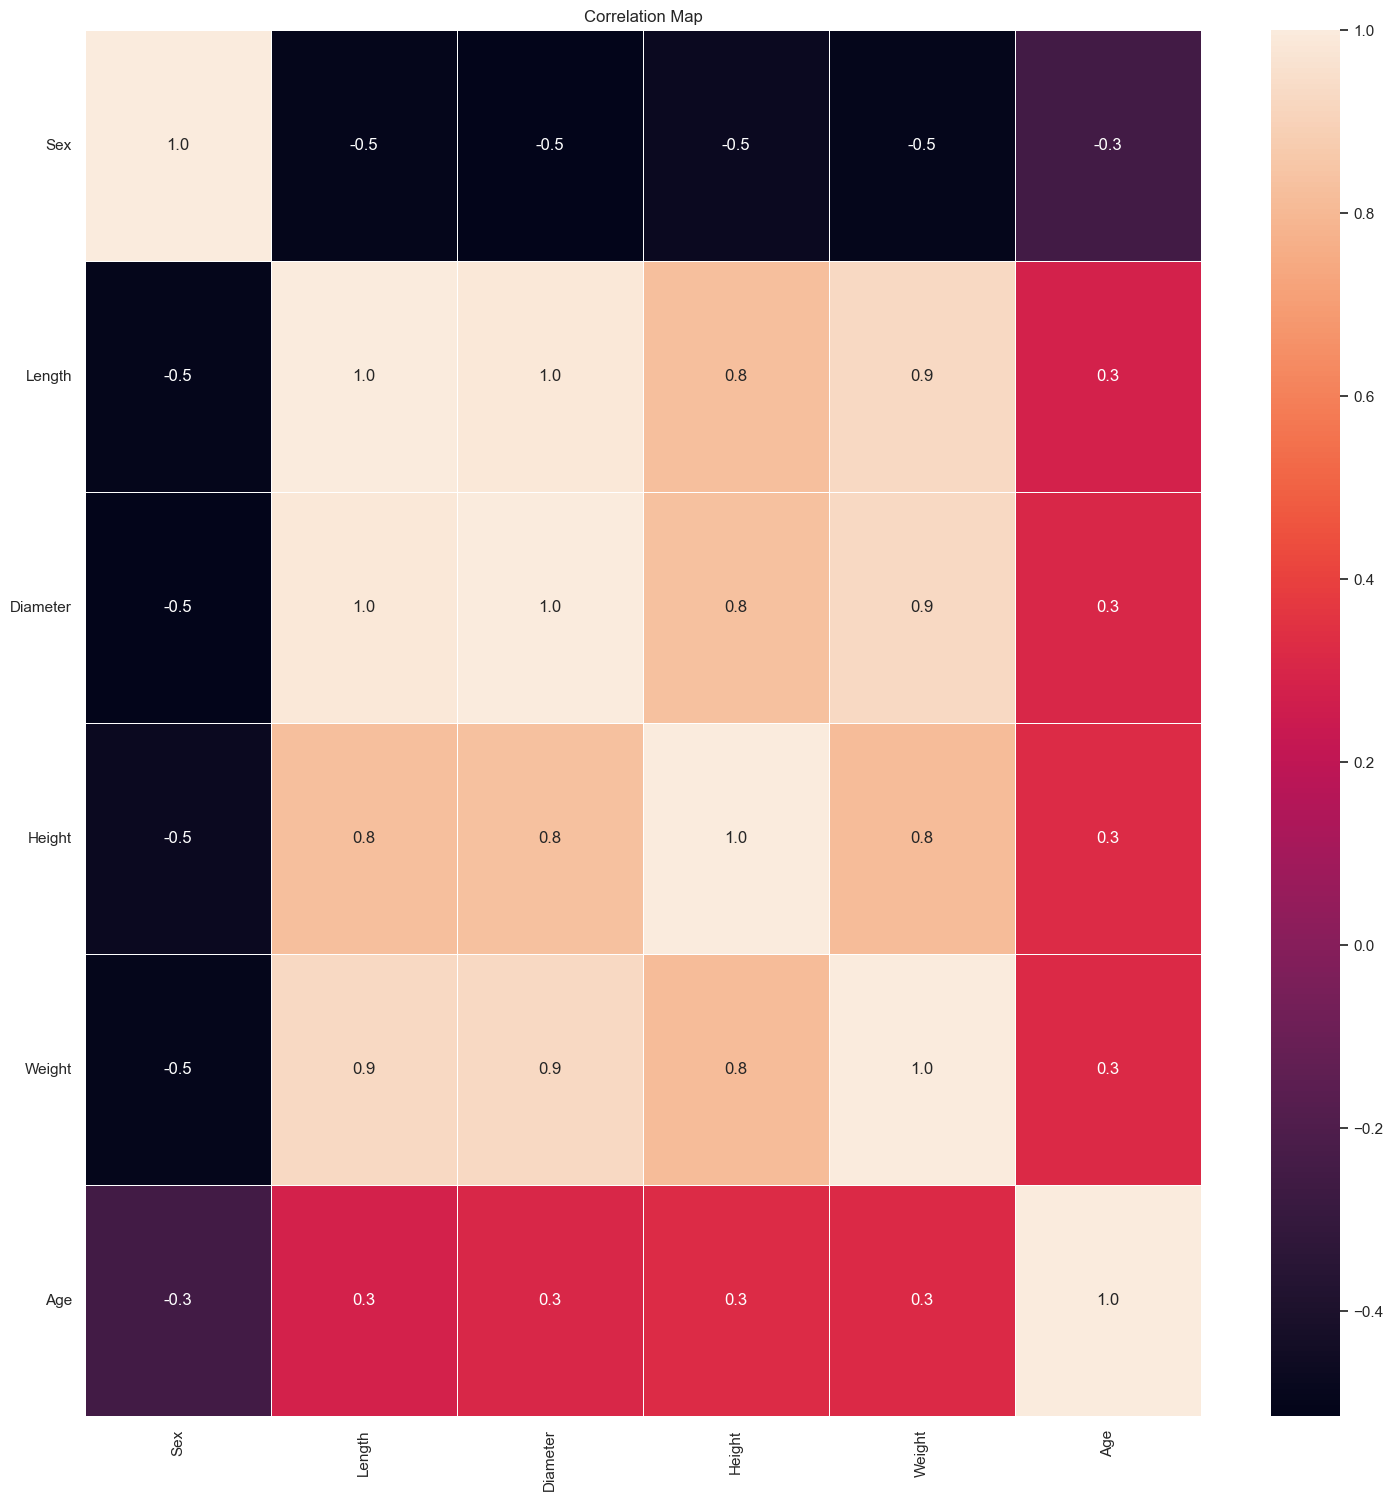

In [24]:
#Create a Heat Map to better understand 
f,ax=plt.subplots(figsize = (18,18))
sns.heatmap(original_data.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

# Using K Nearest Neighbors to Predict Data - 78.56%

In [245]:
# Code from ChatGPT

# Step 1: Initialize the KNN model, specify number of neighbors (k)
# Tests conducted between 1-15. 6 yielded the best results.
k = 6 # You can experiment with different values of k
knn = KNeighborsClassifier(n_neighbors=k)

# Step 2: Train the KNN model on the training dataset
knn.fit(X_train, y_train)

# Step 3: Use the trained model to make predictions on the test dataset
y_pred = knn.predict(X_test)

# Step 4: Evaluate the model

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.785622593068036
Confusion Matrix:
[[596  26]
 [141  16]]


# Using RBF SVM (Radialk Basis Function Support Vector Machine) to Predict Data - 79.08%

In [248]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 1: Initialize the RBF SVM model
rbf_svm = SVC(kernel='rbf')

# Step 2: Train the RBF SVM model on the training data
rbf_svm.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = rbf_svm.predict(X_test)

# Step 4: Evaluate the model

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7907573812580231
Confusion Matrix:
[[613   9]
 [154   3]]


# Using XGBoost to Predict Data - 76.89%

In [260]:
# Step 1: Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Step 2: Train the model on the training data
xgb_model.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = xgb_model.predict(X_test)

# Step 4: Evaluate the model

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7689345314505777
Confusion Matrix:
[[553  69]
 [111  46]]


C:\Users\njurczyk\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Random Forest - 76.25%

In [272]:
# Code from ChatGPT

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Step 1: Initialize the Random Forest model
# n_estimators is the number of trees in the forest (can be tuned)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = rf_model.predict(X_test)

# Step 4: Evaluate the model

# 4.1. Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 4.2. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# 4.3. Classification report (includes precision, recall, F1-score)
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

# 4.4. ROC AUC Score (useful for evaluating performance on imbalanced data)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.7625160462130937
Confusion Matrix:
[[561  61]
 [124  33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       622
           1       0.35      0.21      0.26       157

    accuracy                           0.76       779
   macro avg       0.59      0.56      0.56       779
weighted avg       0.72      0.76      0.74       779

ROC AUC Score: 0.5560601716263542


# Logistic Regression - 78.95%

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# Code from ChatGPT

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Step 1: Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Step 2: Train the model on the training data
log_reg_model.fit(X_train, y_train)

# Step 3: Make predictions using the trained model on the test data
y_pred = log_reg_model.predict(X_test)


# Step 4: Evaluate the model

# 4.1. Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 4.2. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


# 4.3. Classification report (includes precision, recall, F1-score)
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

# 4.4. ROC AUC Score (useful if your problem has imbalanced classes)

y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")


Accuracy: 0.7894736842105263
Confusion Matrix:
[[600  22]
 [142  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       622
           1       0.41      0.10      0.15       157

    accuracy                           0.79       779
   macro avg       0.61      0.53      0.52       779
weighted avg       0.73      0.79      0.73       779

ROC AUC Score: 0.7124746554160608


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Hyperparameter tuning with GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000), 
    param_grid, 
    cv=5, 
    scoring='roc_auc'  # Optimize for ROC AUC during cross-validation
)
grid_search.fit(X_train_scaled, y_train)

# Use the best model
best_model = grid_search.best_estimator_

# Predict probabilities and labels on the test set
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
y_pred = best_model.predict(X_test_scaled)  # Binary predictions

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

# Output results
print(f"Tuned ROC AUC Score: {roc_auc:.3f}")
print(f"Accuracy on Test Data: {accuracy:.3f}")


Tuned ROC AUC Score: 0.727
Accuracy on Test Data: 0.786


In [78]:
import numpy as np

# Example mapping for "Sex"
sex_mapping = {"F": 0, "M": 1, "I": 2}

# Function to get user input and make a prediction
def predict_crab_ready_to_eat(model, scaler):
    print("Please enter the crab details below:")
    
    # Get inputs from the user
    try:
        sex = input("Enter the sex of the crab (F/M/I): ").strip().upper()
        sex_encoded = sex_mapping[sex]  # Map to numeric value
        
        length = float(input("Enter the length of the crab (in inches): "))
        diameter = float(input("Enter the diameter of the crab (in inches): "))
        height = float(input("Enter the height of the crab (in inches): "))
        weight = float(input("Enter the weight of the crab (in Ounces): "))
    except KeyError:
        print("Invalid input for sex. Please enter F, M, or I.")
        return
    except ValueError:
        print("Invalid numerical input. Please try again.")
        return
    
    # Combine inputs into a feature array
    features = np.array([[sex_encoded, length, diameter, height, weight]])
    
    # Scale the features using the same scaler used during training
    features_scaled = scaler.transform(features)
    
    # Make prediction using the trained model
    probability = model.predict_proba(features_scaled)[0, 1]  # Probability of class 1 (ready to eat)
    prediction = model.predict(features_scaled)[0]  # Binary prediction
    
    # Print the results
    print("\nPrediction Results:")
    if prediction == 1:
        print(f"The crab is READY to eat!")
    else:
        print(f"The crab is NOT ready to eat.")

    print("Logistic Regression Model Accuracy: 78.95%")

# Example usage
# Replace 'best_model' and 'scaler' with your actual trained model and scaler
predict_crab_ready_to_eat(log_reg_model, scaler)


Please enter the crab details below:


Enter the sex of the crab (F/M/I):  F
Enter the length of the crab (in inches):  1.5
Enter the diameter of the crab (in inches):  1.5
Enter the height of the crab (in inches):  1.5
Enter the weight of the crab (in Ounces):  1.5



Prediction Results:
The crab is READY to eat!

Logistic Regression Model Accuracy: 78.95%


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
